In [1]:
import pandas as pd #
import numpy as np
from joblib import load
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
import seaborn as sns

crit_thresh = -0.094870
warn_thresh = -0.042534

# Load Isolation Forest model and scaler
scaler = load('./model/iso_scaler.joblib')
iso_model = load('./model/iso_model.joblib')

# Load datasets
#df_val = pd.read_csv("./data/validate.csv")
df_val = pd.read_csv("./../../data/dataSet1_prepared.csv")
#df1 = pd.read_csv("./data/dev101_prepared.csv")
#df2 = pd.read_csv("./data/dev102_prepared.csv")

#df_val = pd.concat([df1, df2], ignore_index=True)
df_val = df_val.sort_values('timestamp').reset_index(drop=True)

In [2]:
df_val

,timestamp,devID,soil,rain,temp,humi,geo,lat,lng,hour,day_of_week
0,2025-05-02 11:42:00.384119,102.0,22.200001,0.0,34.549099,61.175941,3.323395,8.637964,99.898933,11,4
1,2025-05-02 11:42:06.635276,101.0,28.799999,0.0,34.290073,62.429081,14.532875,8.637999,99.899010,11,4
2,2025-05-02 11:42:11.034615,102.0,22.200001,0.0,34.506374,61.542152,14.766250,8.637963,99.898933,11,4
3,2025-05-02 11:42:18.056572,101.0,28.799999,0.0,34.266041,64.082787,14.673310,8.637998,99.899010,11,4
4,2025-05-02 11:42:21.675224,102.0,22.200001,0.0,34.485012,61.767223,3.242806,8.637963,99.898933,11,4
...,...,...,...,...,...,...,...,...,...,...,...
375604,2025-07-22 19:39:28.596,101.0,25.600000,0.0,28.682386,74.146103,7.982772,8.638018,99.898956,19,1
375605,2025-07-22 19:39:35.152,102.0,23.299999,0.0,28.653008,73.873352,5.533101,8.637944,99.898926,19,1
375606,2025-07-22 19:39:41.789,101.0,25.600000,0.0,28.674376,74.270081,0.931764,8.638016,99.898956,19,1
375607,2025-07-22 19:39:48.552,102.0,23.299999,0.0,28.631645,73.905777,6.762322,8.637944,99.898926,19,1


In [3]:
#df_val  = pd.concat([df1, df2], ignore_index=True)
df_val.describe()

,devID,soil,rain,temp,humi,geo,lat,lng,hour,day_of_week
count,375609.000000,375609.000000,375609.000000,375609.000000,375609.000000,375609.000000,375609.000000,375609.000000,375609.000000,375609.000000
mean,101.502898,43.992966,0.165806,29.900678,74.567455,8.239718,8.637978,99.901333,11.508755,3.100647
std,0.499992,13.708053,1.579886,3.189388,8.844493,6.654768,0.000038,1.461406,7.050659,1.968851
min,101.000000,20.200001,0.000000,24.238958,43.418247,0.000000,8.637330,99.166664,0.000000,0.000000
25%,101.000000,28.500000,0.000000,27.397957,68.698631,3.001680,8.637944,99.898926,5.000000,1.000000
50%,102.000000,46.799999,0.000000,28.586250,78.603645,4.549040,8.637974,99.898949,12.000000,3.000000
75%,102.000000,56.000000,0.000000,32.695885,80.863892,13.630129,8.638015,99.898972,18.000000,5.000000
max,102.000000,66.599998,41.630600,39.331657,88.510567,32.062466,8.638361,995.549988,23.000000,6.000000


## Threshold

In [4]:
#def rule_based_risk(row):
#   score = 0
#   
#   # Rainfall (mm/h)
#   if row['rain'] > 25:
#       score += 2
#   elif row['rain'] > 10:
#       score += 1
#
#   # Soil moisture (%)
#   if row['soil'] > 60:
#       score += 2
#   elif row['soil'] > 45:
#       score += 1
#
#   # Temperature (°C)
#   if row['temp'] < 27:
#       score += 2
#   elif row['temp'] < 32:
#       score += 1
#
#   # Humidity (%)
#   if row['humi'] > 80:
#       score += 2
#   elif row['humi'] > 65:
#       score += 1
#
#   # Geophone (Hz)
#   if row['geo'] > 25:
#       score += 1
#   elif row['geo'] > 10:
#       score += 0.5
#
#   if score >= 6:
#       return "Critical"
#   elif score >= 3:
#       return "Warning"
#   else:
#       return "Normal"
#
#feature_cols = ['soil', 'rain', 'temp', 'humi', 'geo']
#X_val = df_val[feature_cols].values
#X_val_scaled = scaler.transform(X_val)
#
#df_val['anomaly_score'] = iso_model.decision_function(X_val_scaled)
#
#crit_thresh = np.percentile(df_val['anomaly_score'], 0.5)
#warn_thresh = np.percentile(df_val['anomaly_score'], 5)
#
#def model_based_risk(score):
#   if score < crit_thresh:
#       return "Critical"
#   elif score < warn_thresh:
#       return "Warning"
#   else:
#       return "Normal"
#
#df_val['model_risk'] = df_val['anomaly_score'].apply(model_based_risk)
#df_val['rule_risk'] = df_val.apply(rule_based_risk, axis=1)
#
#risk_levels = {'Normal': 0, 'Warning': 1, 'Critical': 2}
#
#def combine_weighted_risks(model_risk, rule_risk, w_model=0.6, w_rule=0.4):
#   score = w_model * risk_levels[model_risk] + w_rule * risk_levels[rule_risk]
#   
#   if score >= 1.5:
#       return "Critical"
#   elif score >= 0.5:
#       return "Warning"
#   else:
#       return "Normal"
#
#df_val['predicted_risk'] = df_val.apply(
#    lambda row: combine_weighted_risks(row['model_risk'], row['rule_risk']),
#    axis=1
#)
#
#print(df_val[['soil', 'rain', 'temp', 'humi', 'geo',
#              'anomaly_score', 'model_risk', 'rule_risk', 'predicted_risk']].head())

In [5]:
# สร้าง features
feature_cols = ['soil', 'rain', 'temp', 'humi', 'geo']
X_val = df_val[feature_cols].values
X_val_scaled = scaler.transform(X_val)

# คำนวณ anomaly score และจัดระดับความเสี่ยง
df_val['anomaly_score'] = iso_model.decision_function(X_val_scaled)


#crit_thresh = np.percentile(df_val['anomaly_score'], 0.25)
#warn_thresh = np.percentile(df_val['anomaly_score'], 0.75)
#crit_thresh = -0.094870
#warn_thresh = -0.042534

def classify_risk(score):
    if score < crit_thresh:
        return "Critical"
    elif score < warn_thresh:
        return "Warning"
    else:
        return "Normal"

df_val['predicted_risk'] = df_val['anomaly_score'].apply(classify_risk)

In [6]:
print("crit_thresh:", np.percentile(df_val['anomaly_score'], 0.433))
print("warn_thresh:", np.percentile(df_val['anomaly_score'], 2.226))

crit_thresh: -0.09488094340643279
warn_thresh: -0.04248572177690142


In [7]:
critical_group = df_val[df_val['anomaly_score'] < crit_thresh]
print("critical_group")
print(critical_group[feature_cols].describe())

critical_group
              soil         rain         temp         humi          geo
count  1627.000000  1627.000000  1627.000000  1627.000000  1627.000000
mean     48.374308    16.479620    29.229940    74.299782    18.332853
std      16.034921    11.825099     4.458349    12.966211     9.669152
min      20.400000     0.000000    25.013353    44.434883     0.656139
25%      26.550000     5.029200    26.356527    79.714699    14.230779
50%      54.000000    16.764000    27.154955    80.743729    18.418867
75%      62.350000    25.984200    27.869267    81.376976    20.031505
max      66.400002    41.630600    39.312965    88.413284    32.058685


In [8]:
warn_group = df_val[(df_val['anomaly_score'] < warn_thresh) & (df_val['anomaly_score'] >= crit_thresh) ]
print("warn_group")
print(warn_group[feature_cols].describe())

warn_group
              soil         rain         temp         humi          geo
count  6725.000000  6725.000000  6725.000000  6725.000000  6725.000000
mean     29.648981     1.961492    34.311630    58.955635    12.657458
std      13.430208     4.938584     3.965424    12.135832     9.421302
min      20.200001     0.000000    24.652859    43.418247     0.639543
25%      22.000000     0.000000    33.694588    51.106892     3.646844
50%      23.100000     0.000000    36.161972    52.854046    13.162091
75%      26.299999     0.000000    36.906998    61.158775    17.751478
max      66.599998    31.013399    39.331657    88.392303    32.062378


In [9]:
normal_group = df_val[df_val['anomaly_score'] >= warn_thresh]
print("normal_group")
print(normal_group[feature_cols].describe())

normal_group
                soil           rain           temp           humi  \
count  367257.000000  367257.000000  367257.000000  367257.000000   
mean       44.236215       0.060652      29.822879      74.854516   
std        13.558451       0.487865       3.108585       8.486308   
min        20.200001       0.000000      24.238958      47.727016   
25%        30.500000       0.000000      27.395287      69.228882   
50%        47.000000       0.000000      28.556877      78.672310   
75%        56.099998       0.000000      32.447548      80.879150   
max        66.400002      11.734800      38.984512      88.510567   

                 geo  
count  367257.000000  
mean        8.114109  
std         6.513800  
min         0.000000  
25%         2.991805  
50%         4.477765  
75%        13.411043  
max        32.062466  


C:\Users\ahmad\AppData\Local\Temp\ipykernel_13648\2053204387.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_val, x='predicted_risk', order=['Normal', 'Warning', 'Critical'], palette='Set2')


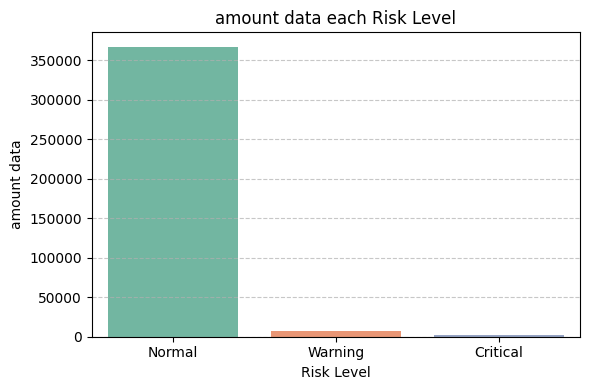

In [10]:

plt.figure(figsize=(6, 4))
sns.countplot(data=df_val, x='predicted_risk', order=['Normal', 'Warning', 'Critical'], palette='Set2')

plt.title('amount data each Risk Level')
plt.xlabel('Risk Level')
plt.ylabel('amount data')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Distribution of Anomaly Scores

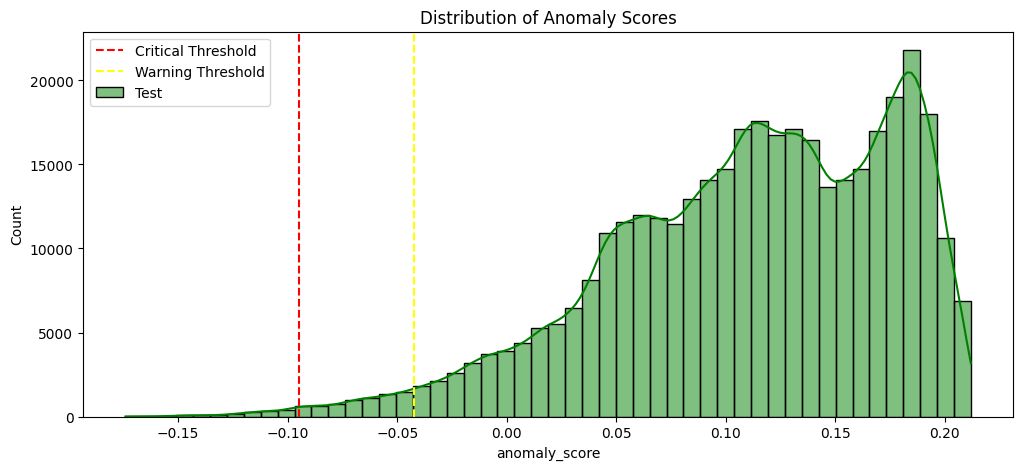

In [11]:
plt.figure(figsize=(12,5))
sns.histplot(df_val['anomaly_score'], bins=50, kde=True, color='green', label='Test')
plt.axvline(crit_thresh, color='red', linestyle='--', label='Critical Threshold')
plt.axvline(warn_thresh, color='yellow', linestyle='--', label='Warning Threshold')
plt.legend()
plt.title('Distribution of Anomaly Scores')
plt.show()



## Z-score Outlier

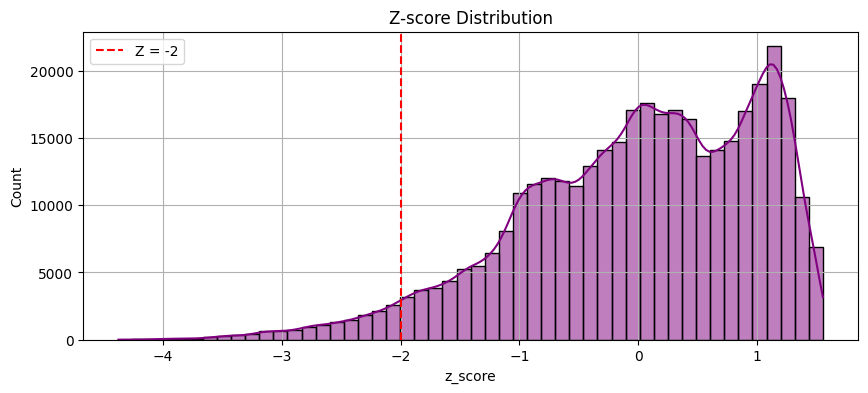

In [12]:
# ==== Z-score Outlier ====

mean_score = df_val['anomaly_score'].mean()
std_score = df_val['anomaly_score'].std()
df_val['z_score'] = (df_val['anomaly_score'] - mean_score) / std_score
df_val['z_outlier'] = df_val['z_score'].apply(lambda z: 'Anomaly' if z < -2 else 'Normal')

plt.figure(figsize=(10,4))
sns.histplot(df_val['z_score'], kde=True, bins=50, color='purple')
plt.axvline(-2, color='red', linestyle='--', label='Z = -2')
plt.title("Z-score Distribution")
plt.legend()
plt.grid(True)
plt.show()

## Mahalanobis Distance

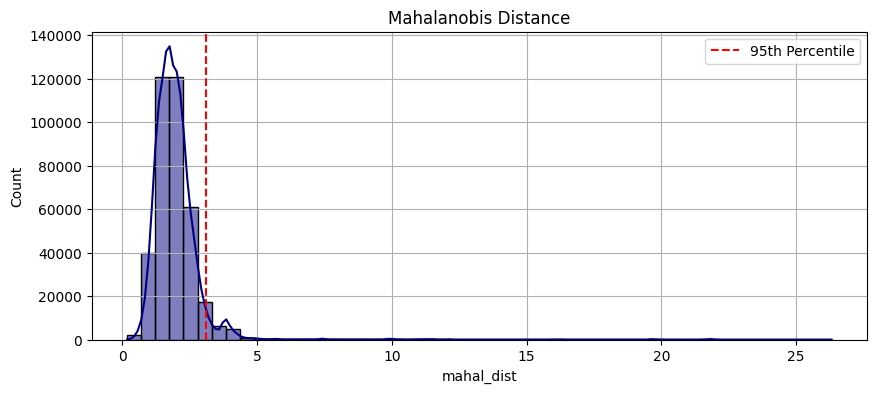

In [13]:
mean_vec = np.mean(X_val_scaled, axis=0)
cov_matrix = np.cov(X_val_scaled, rowvar=False)
inv_covmat = np.linalg.inv(cov_matrix)

df_val['mahal_dist'] = [mahalanobis(x, mean_vec, inv_covmat) for x in X_val_scaled]
mahal_thresh = np.percentile(df_val['mahal_dist'], 95)
df_val['mahal_outlier'] = df_val['mahal_dist'].apply(lambda d: 'Anomaly' if d > mahal_thresh else 'Normal')

plt.figure(figsize=(10,4))
sns.histplot(df_val['mahal_dist'], bins=50, kde=True, color='navy')
plt.axvline(mahal_thresh, color='red', linestyle='--', label='95th Percentile')
plt.title("Mahalanobis Distance")
plt.legend()
plt.grid(True)
plt.show()

## Percentile Threshold 5%

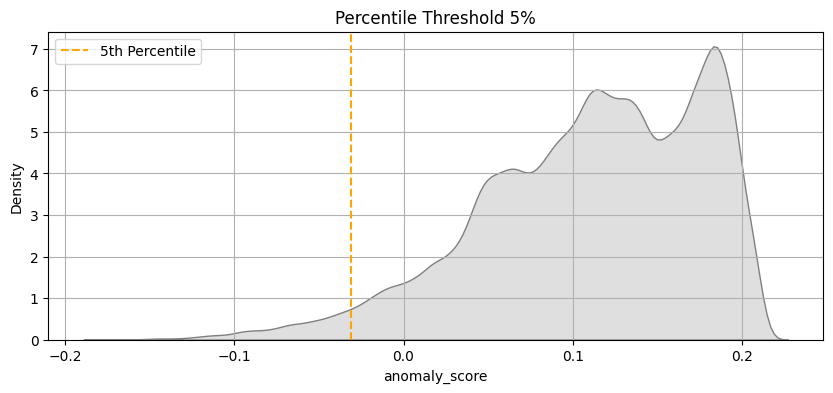

In [14]:
percentile = np.percentile(df_val['anomaly_score'], 3)
df_val['percentile_outlier'] = df_val['anomaly_score'].apply(lambda s: 'Anomaly' if s < percentile else 'Normal')

plt.figure(figsize=(10,4))
sns.kdeplot(df_val['anomaly_score'], fill=True, color='gray')
plt.axvline(percentile, color='orange', linestyle='--', label='5th Percentile')
plt.title("Percentile Threshold 5%")
plt.legend()
plt.grid(True)
plt.show()

## PCA

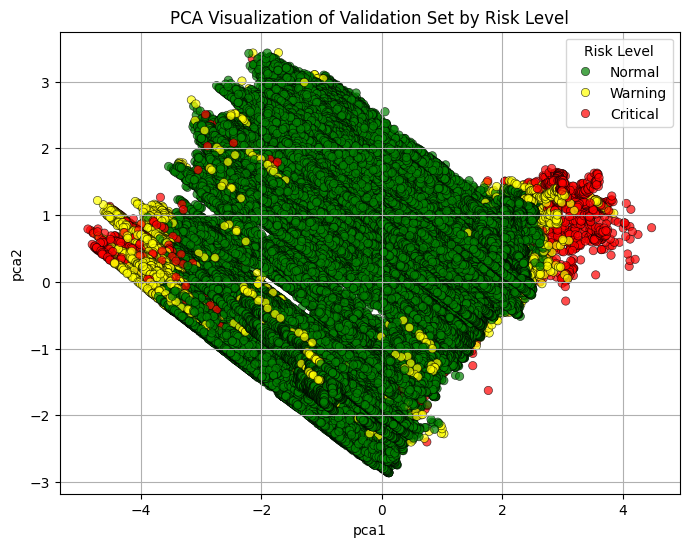

In [15]:
# Fit PCA
pca = PCA(n_components=2)
X_val_pca = pca.fit_transform(X_val_scaled)

# เพิ่มค่า PCA กลับเข้า df_val
df_val['pca1'] = X_val_pca[:, 0]
df_val['pca2'] = X_val_pca[:, 1]

# Map สีแบบกำหนดเอง
custom_palette = {
    'Normal': 'green',
    'Warning': 'yellow',
    'Critical': 'red'
}

# วาดกราฟ
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_val,
    x='pca1', y='pca2',
    hue='predicted_risk',
    palette=custom_palette,
    alpha=0.7,
    edgecolor='black'
)
plt.title('PCA Visualization of Validation Set by Risk Level')
plt.grid(True)
plt.legend(title='Risk Level')
plt.show()

In [16]:
explained_var = pca.explained_variance_ratio_
print(f"PCA explain {explained_var[0]*100:.2f}% and {explained_var[1]*100:.2f}% of data")


PCA explain 39.51% and 27.43% of data


In [17]:
# ดูว่าแต่ละ feature มีน้ำหนักกับแต่ละ principal component เท่าไหร่ x=PC1 y=PC2
pca_df = pd.DataFrame(pca.components_, columns=feature_cols, index=["PC1", "PC2"])
print(pca_df.T.sort_values("PC1", ascending=False))  # เรียงตามผลต่อแกน X


           PC1       PC2
humi  0.597110 -0.393079
soil  0.563394  0.819137
rain  0.102123  0.038809
geo  -0.000649  0.066019
temp -0.561798  0.410656


## Summary Statistics

In [18]:
print("\n== Z-score Outlier ==")
print(df_val['z_outlier'].value_counts())


== Z-score Outlier ==
z_outlier
Normal     360705
Anomaly     14904
Name: count, dtype: int64


In [19]:
print("\n== Percentile Outlier ==")
print(f"5th Percentile Threshold: {percentile:.4f}")
print(df_val['percentile_outlier'].value_counts())


== Percentile Outlier ==
5th Percentile Threshold: -0.0308
percentile_outlier
Normal     364340
Anomaly     11269
Name: count, dtype: int64


In [20]:
print("\n== Mahalanobis Outlier ==")
print(f"95th Percentile of Mahalanobis Distance: {mahal_thresh:.2f}")
print(df_val['mahal_outlier'].value_counts())


== Mahalanobis Outlier ==
95th Percentile of Mahalanobis Distance: 3.09
mahal_outlier
Normal     356828
Anomaly     18781
Name: count, dtype: int64


In [21]:
overlap = df_val[
    (df_val['z_outlier'] == 'Anomaly') &
    (df_val['percentile_outlier'] == 'Anomaly') &
    (df_val['mahal_outlier'] == 'Anomaly')
]
print(f"Anomalies detected by ALL 3 methods: {len(overlap)}")


Anomalies detected by ALL 3 methods: 6615


In [22]:
df_val['combined_outlier'] = df_val.apply(
    lambda row: (
        row['z_outlier'] == 'Anomaly' or
        row['percentile_outlier'] == 'Anomaly' or
        row['mahal_outlier'] == 'Anomaly'
    ),
    axis=1
)

print("\n== Combined Outlier ==")
print(df_val['combined_outlier'].value_counts())


== Combined Outlier ==
combined_outlier
False    349780
True      25829
Name: count, dtype: int64


In [23]:
print("\n== Mean Feature Values by Risk Level ==")
print(df_val.groupby('predicted_risk')[feature_cols].mean())


== Mean Feature Values by Risk Level ==
                     soil       rain       temp       humi        geo
predicted_risk                                                       
Critical        48.374308  16.479620  29.229940  74.299782  18.332853
Normal          44.236215   0.060652  29.822879  74.854516   8.114109
Warning         29.648981   1.961492  34.311630  58.955635  12.657458


In [24]:
print("\n== Risk Level ==")
print(df_val['predicted_risk'].value_counts())


== Risk Level ==
predicted_risk
Normal      367257
Warning       6725
Critical      1627
Name: count, dtype: int64


In [25]:
def risk_from_combined(row):
    if row['combined_outlier']:
        if row['anomaly_score'] < crit_thresh:
            return 'Critical'
        elif row['anomaly_score'] < warn_thresh:
            return 'Warning'
        else:
            return 'Warning'  
    return 'Normal'

df_val['risk_level_final'] = df_val.apply(risk_from_combined, axis=1)
print("\n== risk level final ==")
print(df_val['risk_level_final'].value_counts())


== risk level final ==
risk_level_final
Normal      349780
Warning      24202
Critical      1627
Name: count, dtype: int64


In [26]:
print("\n== Risk final Proportion ==")
print("Validation:", df_val['risk_level_final'].value_counts(normalize=True))


== Risk final Proportion ==
Validation: risk_level_final
Normal      0.931234
Warning     0.064434
Critical    0.004332
Name: proportion, dtype: float64


In [27]:
print("\n== Risk Proportion ==")
print("Validation:", df_val['predicted_risk'].value_counts(normalize=True))


== Risk Proportion ==
Validation: predicted_risk
Normal      0.977764
Warning     0.017904
Critical    0.004332
Name: proportion, dtype: float64


##  Signal-to-Noise Ratio (SNR)

In [28]:
def compute_snr(signal):
    mean_signal = np.mean(signal)
    std_signal = np.std(signal)
    return mean_signal / std_signal if std_signal != 0 else 0

for col in feature_cols:
    snr = compute_snr(df_val[col])
    print(f"SNR of {col}: {snr:.2f}")


SNR of soil: 3.21
SNR of rain: 0.10
SNR of temp: 9.38
SNR of humi: 8.43
SNR of geo: 1.24


In [29]:
for col in feature_cols:
    normal_snr = compute_snr(df_val[df_val['predicted_risk'] == 'Normal'][col])
    anomaly_snr = compute_snr(df_val[df_val['predicted_risk'] != 'Normal'][col])
    print(f"{col}: Normal SNR={normal_snr:.2f}, Anomaly SNR={anomaly_snr:.2f}")


soil: Normal SNR=3.26, Anomaly SNR=2.10
rain: Normal SNR=0.12, Anomaly SNR=0.54
temp: Normal SNR=9.59, Anomaly SNR=7.35
humi: Normal SNR=8.82, Anomaly SNR=4.52
geo: Normal SNR=1.25, Anomaly SNR=1.41


## Mean Absolute Error (MAE)

In [30]:
df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
interval = df_val['timestamp'].diff().median()
print(f"Sampling interval: {interval}")


Sampling interval: 0 days 00:00:07.404769500


In [31]:
window_size = int(pd.Timedelta('1H') / interval)
print(f"Rolling window size for 1 hour: {window_size}")


Rolling window size for 1 hour: 486


C:\Users\ahmad\AppData\Local\Temp\ipykernel_13648\504831528.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  window_size = int(pd.Timedelta('1H') / interval)


In [32]:
interval = df_val['timestamp'].diff().median()
window_size = int(pd.Timedelta('1H') / interval)

print(f"Using rolling window size = {window_size} for 1 hour")

for col in feature_cols:
    df_val[f'{col}_roll_mean'] = df_val[col].rolling(window=window_size, center=True).mean()
    df_val[f'{col}_mae'] = (df_val[col] - df_val[f'{col}_roll_mean']).abs()

    mae = df_val[f'{col}_mae'].mean()
    print(f"MAE for {col} (vs rolling mean): {mae:.2f}")


Using rolling window size = 486 for 1 hour
MAE for soil (vs rolling mean): 1.82
MAE for rain (vs rolling mean): 0.11
MAE for temp (vs rolling mean): 0.41
MAE for humi (vs rolling mean): 1.72
MAE for geo (vs rolling mean): 5.23


C:\Users\ahmad\AppData\Local\Temp\ipykernel_13648\2248412977.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  window_size = int(pd.Timedelta('1H') / interval)


## Cross-Correlation

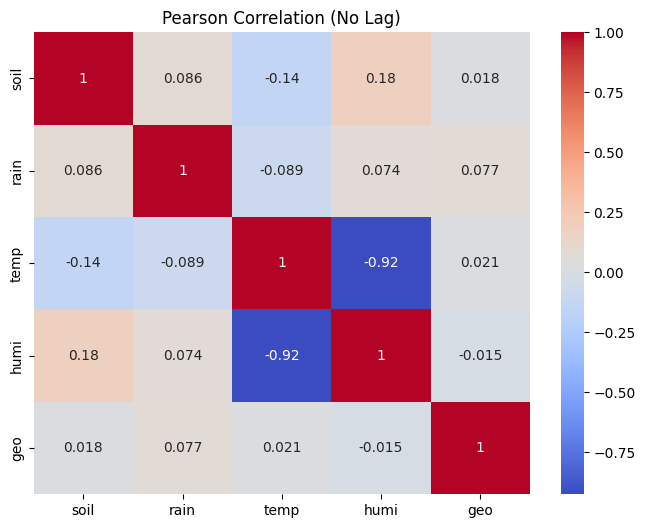

In [33]:
corr_matrix = df_val[feature_cols]
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix.corr(), annot=True, cmap='coolwarm')
plt.title("Pearson Correlation (No Lag)")
plt.show()

In [34]:
def lag_corr(x, y, max_lag=window_size*10):
    lags = []
    corrs = []
    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:
            corr = np.corrcoef(x[:lag], y[-lag:])[0, 1]
        elif lag > 0:
            corr = np.corrcoef(x[lag:], y[:-lag])[0, 1]
        else:
            corr = np.corrcoef(x, y)[0, 1]
        lags.append(lag)
        corrs.append(corr)
    return lags, corrs


In [35]:
#x = df_val['rain'].fillna(method='ffill').values
#y = df_val['soil'].fillna(method='ffill').values
#lags, corrs = lag_corr(x, y, max_lag=window_size*10)
#
#plt.figure(figsize=(10, 5))
#plt.plot(lags, corrs)
#plt.axvline(x=np.argmax(corrs) - 60, color='green', linestyle='--', label='Max Correlation Lag')
#plt.title("Manual Lag Correlation: Rain vs Soil")
#plt.xlabel("Lag (timesteps)")
#plt.ylabel("Correlation")
#plt.grid(True)
#plt.legend()
#plt.show()
#

In [36]:
#x = df_val['rain'].fillna(method='ffill').values
#y = df_val['soil'].fillna(method='ffill').values
#
#x = (x - x.mean()) / x.std()
#y = (y - y.mean()) / y.std()
#
#corr = np.correlate(x, y, mode='full') / len(x)
#lags = np.arange(-len(x)+1, len(x))
#
#plt.figure(figsize=(10,5))
#plt.plot(lags, corr)
#plt.title("np.correlate: Rain vs Soil")
#plt.xlabel("Lag")
#plt.grid(True)
#plt.show()


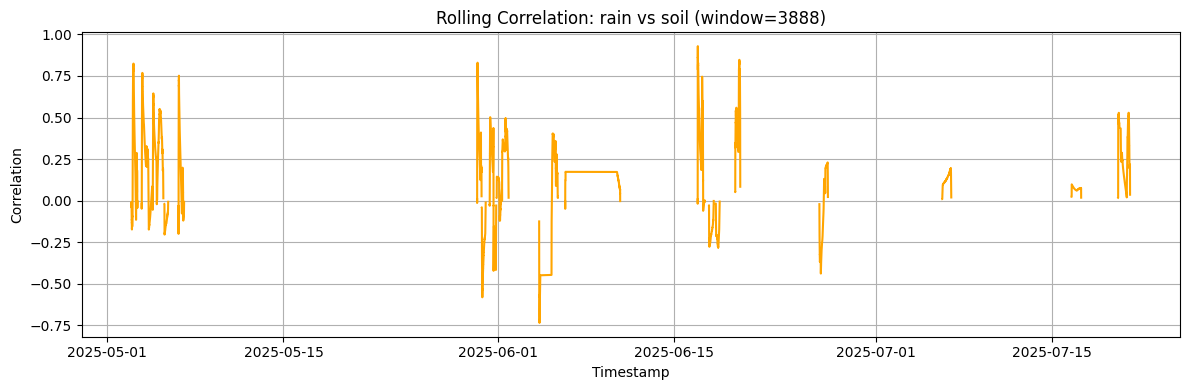

In [37]:
# ตัวอย่าง: ถ้า sampling ทุก 10 นาที → 48 จุด = 8 ชั่วโมง
df = df_val.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

rolling_corr = df['rain'].rolling(window_size*8).corr(df['soil'])

plt.figure(figsize=(12, 4))
plt.plot(df['timestamp'], rolling_corr, color='orange')
plt.title(f"Rolling Correlation: rain vs soil (window={window_size*8})")
plt.xlabel("Timestamp")
plt.ylabel("Correlation")
plt.grid(True)
plt.tight_layout()
plt.show()

## histogram

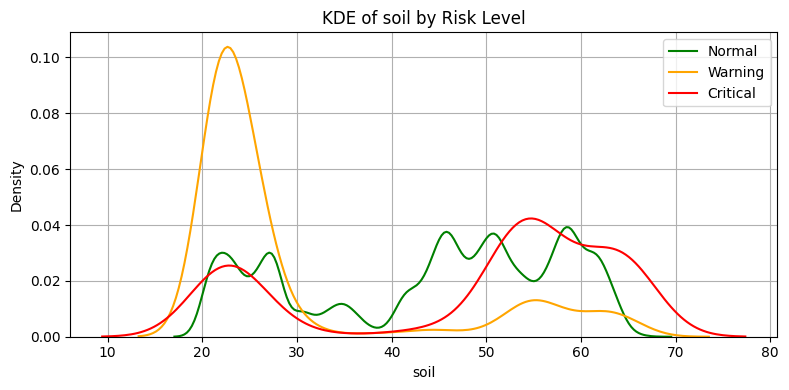

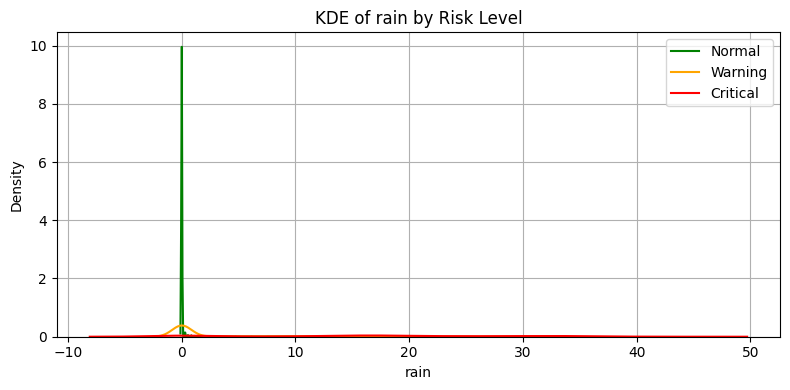

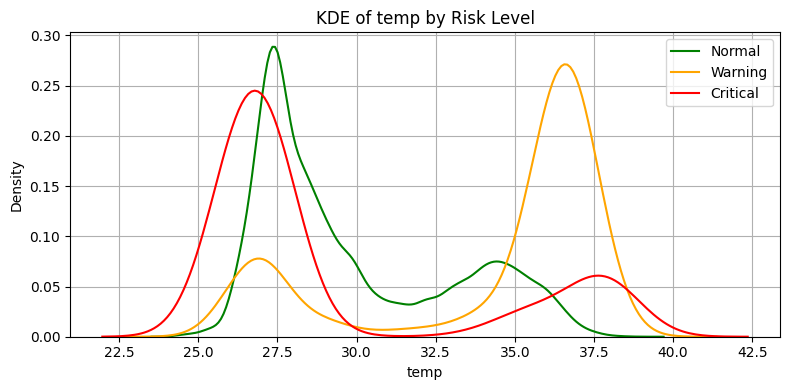

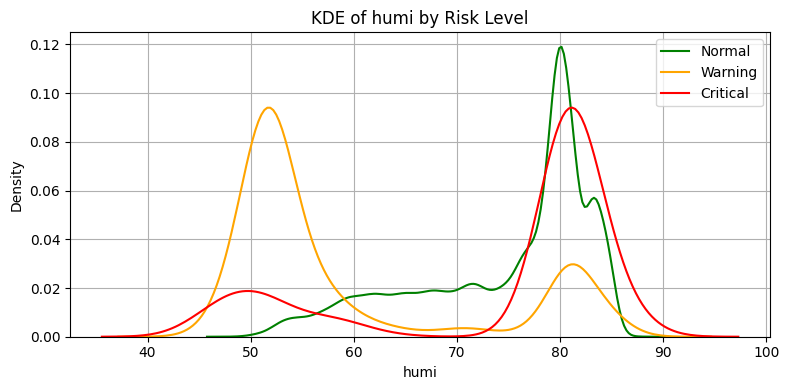

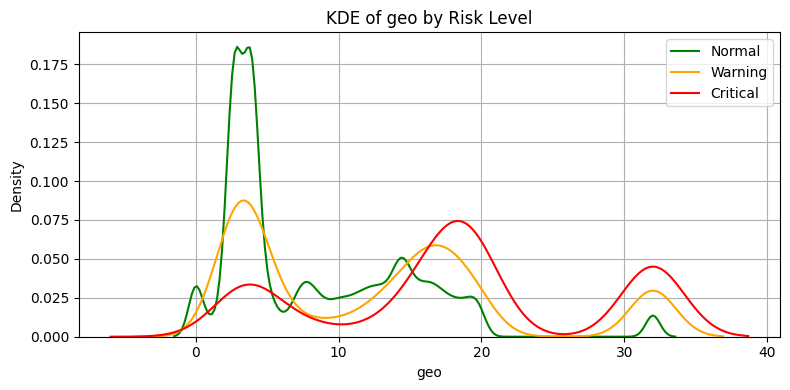

In [38]:
for col in feature_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(df_val[df_val['predicted_risk'] == 'Normal'][col], label='Normal', color='green')
    sns.kdeplot(df_val[df_val['predicted_risk'] == 'Warning'][col], label='Warning', color='orange')
    sns.kdeplot(df_val[df_val['predicted_risk'] == 'Critical'][col], label='Critical', color='red')
    plt.title(f"KDE of {col} by Risk Level")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Box Plot feature by risk

C:\Users\ahmad\AppData\Local\Temp\ipykernel_13648\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\ahmad\AppData\Local\Temp\ipykernel_13648\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\ahmad\AppData\Local\Temp\ipykernel_13648\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\ahmad\AppData\Local\Temp\ipykernel_13648\564551364.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and 

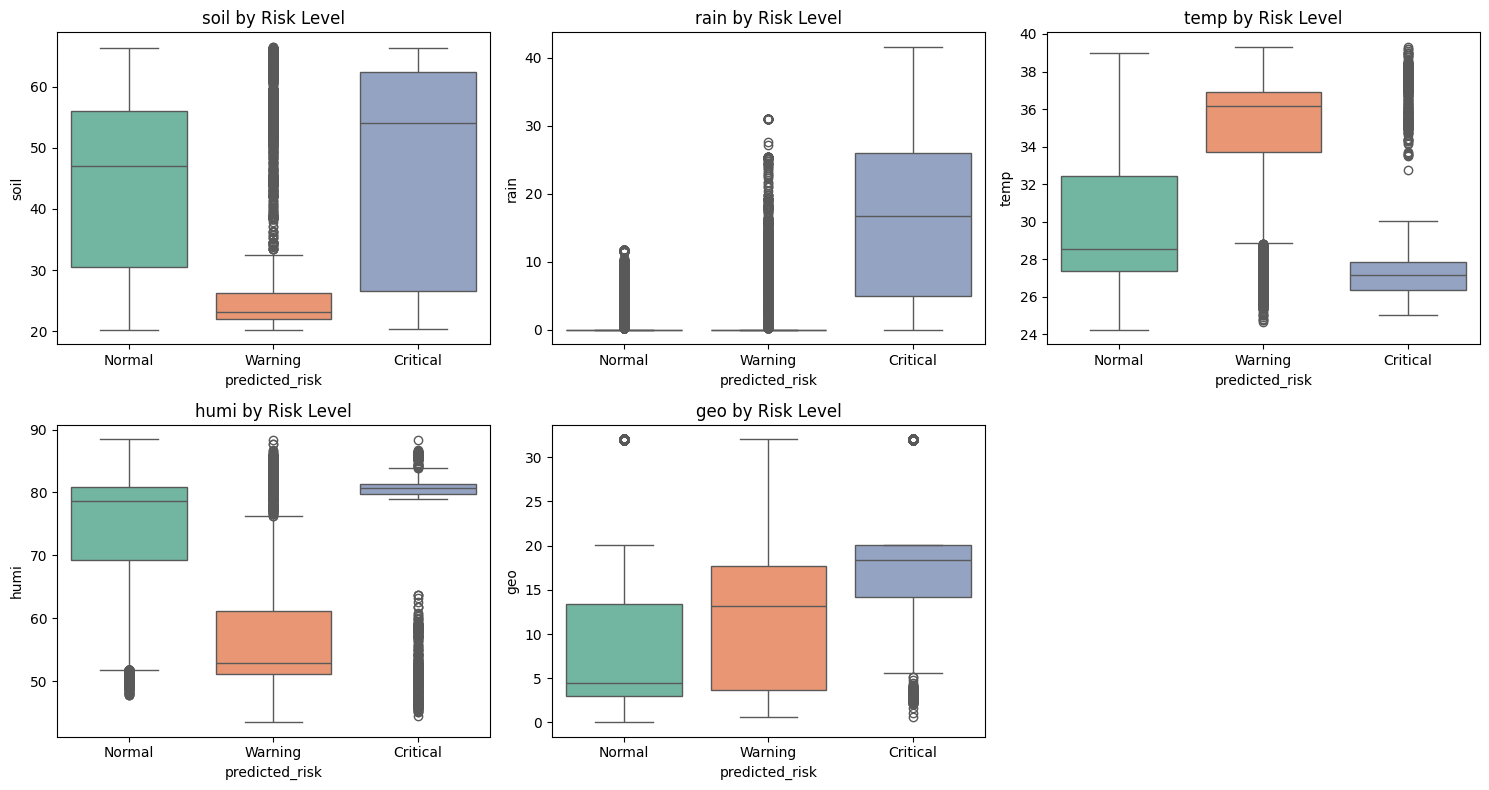

In [39]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(feature_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(
        x='predicted_risk',
        y=col,
        data=df_val,
        order=['Normal', 'Warning', 'Critical'],  # 🔧 fix order here
        palette='Set2'
    )
    plt.title(f'{col} by Risk Level')
plt.tight_layout()
plt.show()


## Time Series

In [40]:
df['timestamp'].min()

Timestamp('2025-05-02 11:42:00.384119')

In [41]:
df['timestamp'].max()

Timestamp('2025-07-22 19:39:55.017000')

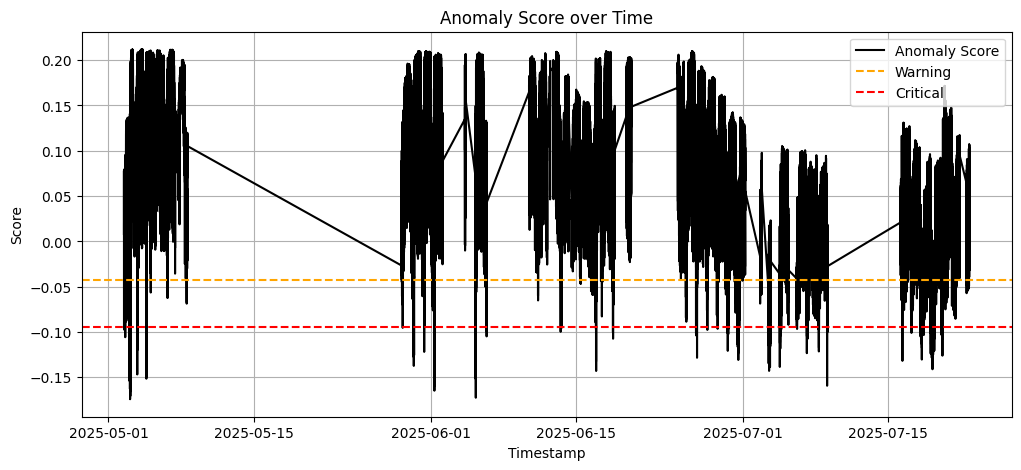

In [42]:
if 'timestamp' in df_val.columns:
    df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
    df_val_sorted = df_val.sort_values('timestamp')

    plt.figure(figsize=(12,5))
    plt.plot(df_val_sorted['timestamp'], df_val_sorted['anomaly_score'], color='black', label='Anomaly Score')
    plt.axhline(warn_thresh, color='orange', linestyle='--', label='Warning')
    plt.axhline(crit_thresh, color='red', linestyle='--', label='Critical')
    plt.title('Anomaly Score over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

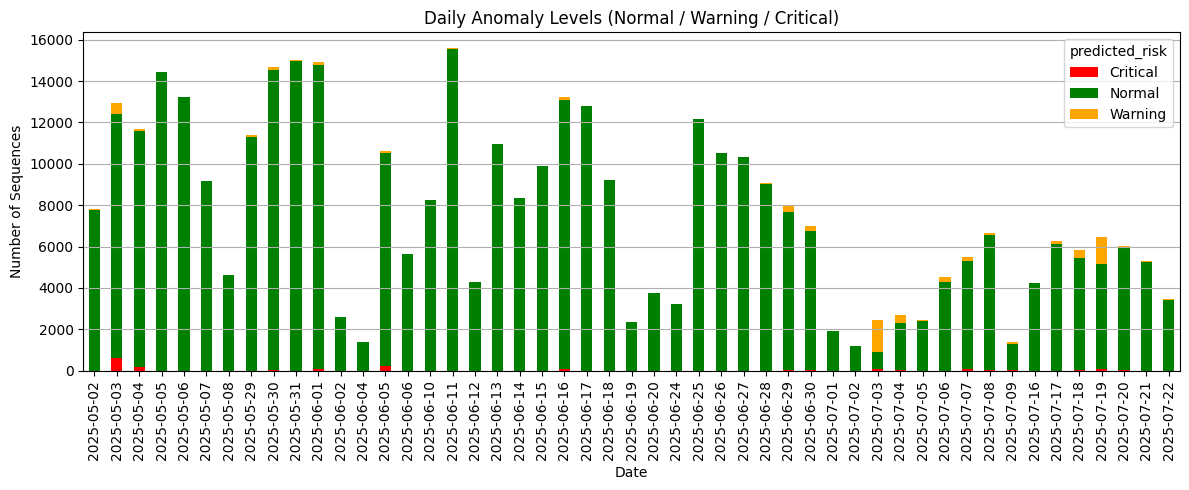

In [43]:

df_results = df_val
df_results['date'] = pd.to_datetime(df_results['timestamp']).dt.date

risk_order = ['Critical', 'Normal', 'Warning']

alerts_per_day = df_results.groupby(['date', 'predicted_risk']).size().unstack(fill_value=0)

for risk in risk_order:
    if risk not in alerts_per_day.columns:
        alerts_per_day[risk] = 0

alerts_per_day = alerts_per_day[risk_order]

colors = ['red', 'green', 'orange']

alerts_per_day.plot(kind='bar', stacked=True, figsize=(12,5), color=colors)

plt.title("Daily Anomaly Levels (Normal / Warning / Critical)")
plt.xlabel("Date")
plt.ylabel("Number of Sequences")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


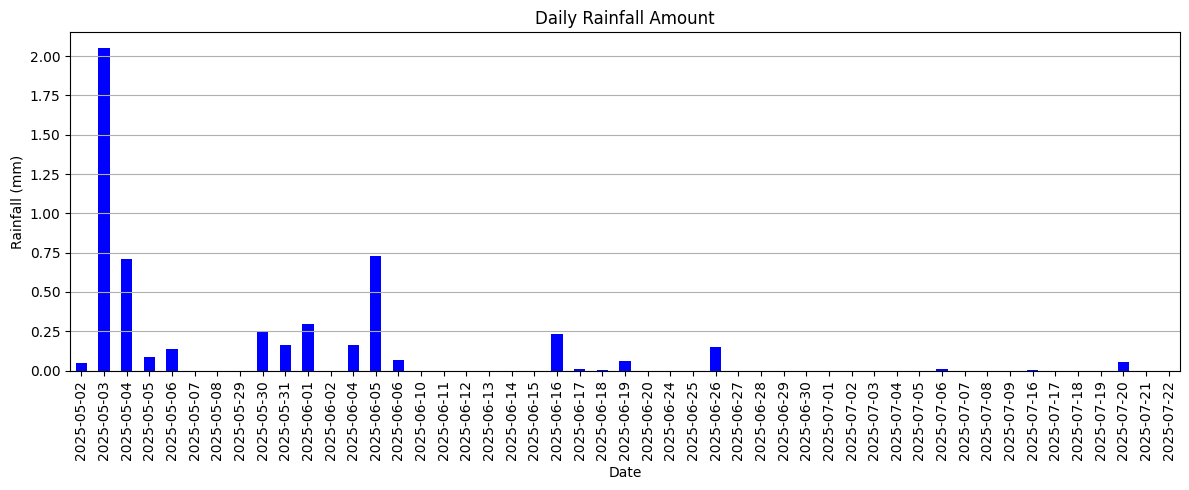

In [44]:

# สมมติ df_rain มี 'timestamp' และ 'rain_amount'

df_results['date'] = pd.to_datetime(df_results['timestamp']).dt.date

# รวมปริมาณฝนรายวัน (sum)
rain_per_day = df_results.groupby('date')['rain'].mean()

# plot กราฟแท่งปริมาณฝนรายวัน
plt.figure(figsize=(12,5))
rain_per_day.plot(kind='bar', color='blue')

plt.title("Daily Rainfall Amount")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


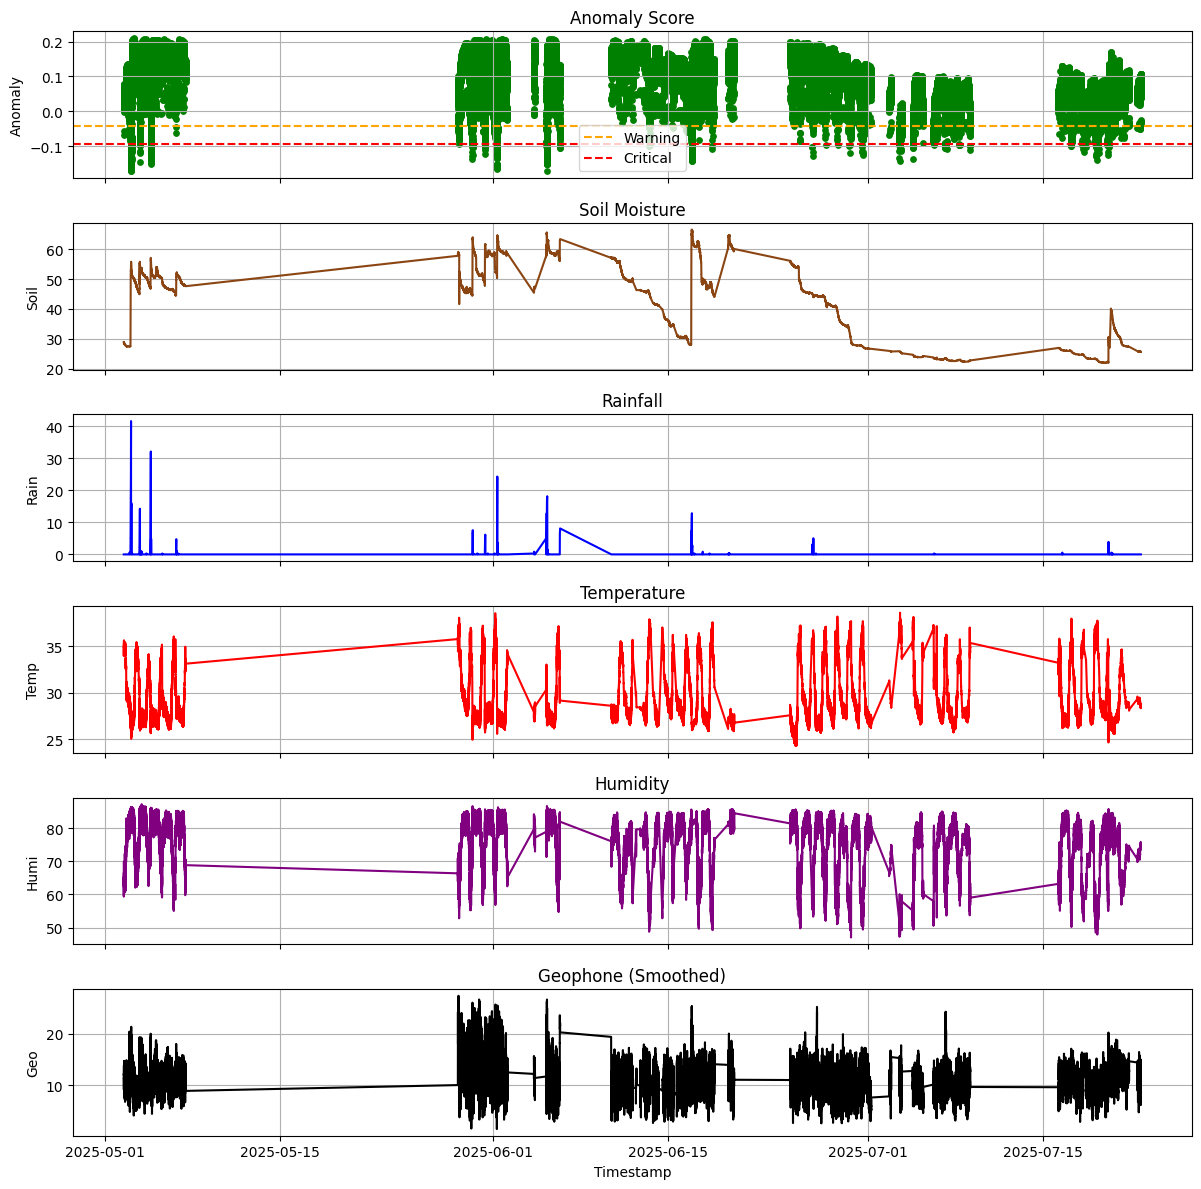

In [55]:
df_val['timestamp'] = pd.to_datetime(df_val['timestamp'])
df_dev = df_val.set_index('timestamp').sort_index()
df_dev = df_dev[df_dev['devID'] == 101.0] 
df_range = df_dev.loc["2025-05-2":"2025-07-22"]

# สร้าง subplot 6 แถว
fig, axs = plt.subplots(6, 1, figsize=(12, 12), sharex=True)

# Plot 1: Anomaly Score
axs[0].scatter(df_range.index, df_range['anomaly_score'], color='green', s=15)
axs[0].axhline(y=warn_thresh, color='orange', linestyle='--', label='Warning')
axs[0].axhline(y=crit_thresh, color='red', linestyle='--', label='Critical')
axs[0].set_ylabel("Anomaly")
axs[0].set_title("Anomaly Score")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Soil
axs[1].plot(df_range.index, df_range['soil'], color='saddlebrown')
axs[1].set_ylabel("Soil")
axs[1].set_title("Soil Moisture")
axs[1].grid(True)

# Plot 3: Rain
axs[2].plot(df_range.index, df_range['rain'], color='blue')
axs[2].set_ylabel("Rain")
axs[2].set_title("Rainfall")
axs[2].grid(True)

# Plot 4: Temp
axs[3].plot(df_range.index, df_range['temp'], color='red')
axs[3].set_ylabel("Temp")
axs[3].set_title("Temperature")
axs[3].grid(True)

# Plot 5: Humi
axs[4].plot(df_range.index, df_range['humi'], color='purple')
axs[4].set_ylabel("Humi")
axs[4].set_title("Humidity")
axs[4].grid(True)

window_size = 20  # ลองปรับค่าตามความเหมาะสม เช่น 10, 50, 100
smoothed_geo = df_range['geo'].rolling(window=window_size).mean()

axs[5].plot(df_range.index, smoothed_geo, color='black')
axs[5].set_ylabel("Geo")
axs[5].set_title("Geophone (Smoothed)")
axs[5].grid(True)

plt.xlabel("Timestamp")
plt.tight_layout()
plt.show()
